In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import preprocessing, cross_validation, metrics #model_selection, 
#from CrossValidation import CVScore
from sklearn.grid_search import GridSearchCV

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import Imputer

import xgboost as xgb
import datetime
from sklearn.metrics import mean_squared_error as mse, make_scorer
from sklearn.cross_validation import train_test_split
#now = datetime.datetime.now()


pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

#id_test = test.id
#multiplier = 0.969

def RMSLE_(y_val, y_val_pred):
    return np.sqrt(np.mean((np.log(y_val+1)-np.log(y_val_pred+1))**2))
RMSLE = make_scorer(RMSLE_, greater_is_better=False) 

def RMSE_(y_val, y_val_pred):
    return np.sqrt(np.mean((y_val-y_val_pred)**2))
RMSE = make_scorer(RMSE_, greater_is_better=False)

from time import time

/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
X_train = pd.read_csv('./input/train_further_additional_feature_filtered.csv',index_col=0)
y_train = pd.read_csv('./input/y_train_further_additional_feature_filtered.csv',index_col=0)['price_doc']
X_test = pd.read_csv('./input/test_further_additional_feature_filtered.csv',index_col=0)
macro = pd.read_csv('./input/macro.csv', parse_dates=['timestamp'])
id_test = pd.read_csv('./input/test.csv').id

In [3]:
imp = Imputer(missing_values=np.nan, strategy='median')
imp.fit(pd.concat([X_train,X_test]))
X_train = pd.DataFrame(imp.transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(imp.transform(X_test),columns=X_test.columns)

In [4]:
imp = Imputer(missing_values=np.infty, strategy='median')
imp.fit(pd.concat([X_train,X_test]))
X_train = pd.DataFrame(imp.transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(imp.transform(X_test),columns=X_test.columns)

In [5]:
target = "price_doc"
predictors = X_train.columns
X_train[target]=y_train

In [8]:
def modelfitGBM(alg, dtrain, predictors, target=target, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    #dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], 
                                                    dtrain[ target], cv=cv_folds, scoring=RMSE)
    
    #Print model report:
    print "\nModel Report"
    #print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions)
    print "RMSE (Train): %f" % RMSE_(dtrain[target], dtrain_predictions)
    
    if performCV:
        print "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)[:50]
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        plt.figure(figsize=(20,10))


Model Report
RMSE (Train): 2392797.398289
CV Score : Mean - -2769655 | Std - 164971.4 | Min - -2959369 | Max - -2572262


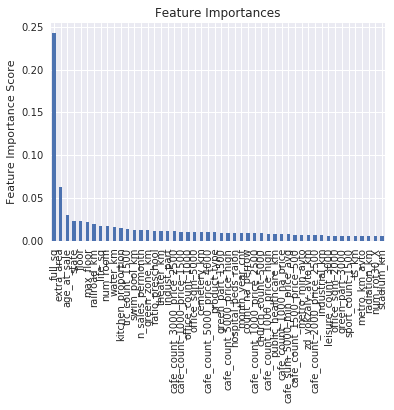

In [9]:
gbm0 = GradientBoostingRegressor(random_state=10)
modelfitGBM(gbm0, X_train, predictors, target)

In [12]:
param_test = {'n_estimators':range(20,81,10)}
gsearch = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=500,
                        min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test, scoring=RMSE, n_jobs=1000,cv=5)#iid=False, 
gsearch.fit(X_train[predictors],X_train[target])
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

([mean: -3154538.97149, std: 262391.11270, params: {'n_estimators': 20},
  mean: -2980372.11446, std: 219382.54487, params: {'n_estimators': 30},
  mean: -2905612.67973, std: 207491.97461, params: {'n_estimators': 40},
  mean: -2863577.50942, std: 198281.73246, params: {'n_estimators': 50},
  mean: -2832082.28393, std: 190805.69465, params: {'n_estimators': 60},
  mean: -2808957.86350, std: 182118.97342, params: {'n_estimators': 70},
  mean: -2795108.14814, std: 179474.00161, params: {'n_estimators': 80}],
 {'n_estimators': 80},
 -2795108.1481437963)

In [15]:
param_test = {'n_estimators':range(80,110,10)}
gsearch = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=500,
                        min_samples_leaf=50,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test, scoring=RMSE, n_jobs=5,cv=5)#iid=False, 
gsearch.fit(X_train[predictors],X_train[target])
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

ImportError: [joblib] Attempting to do parallel computing without protecting your import on a system that does not support forking. To use parallel-computing in a script, you must protect your main loop using "if __name__ == '__main__'". Please see the joblib documentation on Parallel for more information

In [ ]:
param_test = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=80,
                        min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test, scoring=RMSE, n_jobs=1000,cv=5)#iid=False, 
gsearch.fit(X_train[predictors],X_train[target])
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

In [ ]:
t0=time()
rfreg = RandomForestRegressor(max_depth=4, n_estimators=500, n_jobs=-1, random_state=123, max_features='auto')
param_grid = {
       'max_depth': np.arange(3,10,2),
       'max_features': [i/10.0 for i in np.arange(6,10)],
        'random_state':[123]#np.arange(20)
}
model = GridSearchCV(estimator=rfreg, param_grid=param_grid, n_jobs=-1, cv=5, scoring=RMSE)
model.fit(X_train, np.log(y_train+1))
print('Randon Forest Regressor...')
print('Best Params:')
print(model.grid_scores_, model.best_params_)
print('Best CV Score:')
print(-model.best_score_)
print((time()-t0)/60)

Process PoolWorker-9:
Process PoolWorker-11:
Process PoolWorker-12:
Process PoolWorker-10:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 

In [13]:
rfreg = RandomForestRegressor(max_depth=6, n_estimators=500, n_jobs=-1, random_state=123, max_features=.95)
rfreg.fit(X_train, np.log(y_train+1))
y_predict = rfreg.predict(X_test)
y_predict = np.exp(y_predict)-1
#y_predict = np.round(y_predict)#np.round(y_predict * 0.99)
#output = pd.DataFrame({'id': id_test, 'price_doc': y_predict})

In [14]:
output = pd.DataFrame({'id': id_test, 'price_doc': y_predict})
output.to_csv('Jun16_5_RFTuning_maxD6_nEst500_maxFeatPt95_rndSt123.csv', index=False)